# Fit a GP model to the SWOT nadir data

 - Use a Lorentzian in 3D

In [1]:
from gptide import cov
from gptide import GPtideScipy
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az

from scipy import stats
from gptide import stats as gpstats

# The covariance kernel for internal tides
$$
K_{IT}(x, y, t; x', y', t') = \mathcal{M}_{\nu}(x,x'; d_x,\nu) \cos \left( \frac{2\pi(x-x')}{l_x} \right)  \times 
\mathcal{M}_{\nu}(y,y'; d_y,\nu)\cos\left(\frac{2\pi(y-y')}{l_y} \right) \times 
 \mathcal{M}_{\nu}(t,t'; d_t,\nu)\cos\left(\frac{2\pi(t-t')}{l_t}\right)  
$$

where

 - $\mathcal{M}_{\nu}$ is a general Matern function
 - $d_x$, $d_y$ are decay *length* scales
 - $l_x$, $l_y$ are internal wave oscillatory length scales (i.e. wave length)
 - $d_t$ are decay *time* scales
 - $l_t$ are internal wave oscillatory time scales (i.e. wave period)
 
Note that when $\nu=1/2$ or $\mathcal{M}_{1/2}$, the Matern is equivalent to an exponential kernel. A $\mathcal{M}_{1/2}$ multiplied by a cosine kernel results in a signal with a Lorentzian spectrum i.e. a spectral cusp. This is a special case only and not necessarily normal.


In [2]:
def oscillate_1d(x, xpr, params, itfunc=cov.matern12):
    """
    1D Oscillatory kernel
    """
    eta, d, l = params
    
    return eta**2 * itfunc(x, xpr, d) * cov.cosine(x, xpr, l)

def K_itide_3d(x, xpr, params, **kwargs):
    eta, dx, dy, dt, lx, ly, lt = params

    # Build the covariance matrix
    C  = oscillate_1d(x[:,0,None], xpr.T[:,0,None].T, (1, dx, lx), **kwargs)
    C  *= oscillate_1d(x[:,1,None], xpr.T[:,1,None].T, (1, dy, ly), **kwargs)
    C  *= oscillate_1d(x[:,2,None], xpr.T[:,2,None].T, (1, dt, lt), **kwargs)
    C *= eta**2

    return C

In [4]:
# Load the SWOT nadir data and prepare the X,Y,T coordinates into something a GP can handle...
import xarray as xr
from sfoda.utils.myproj import MyProj

#swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarApr2023.nc')
# swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarApr2023_w_iwatlas.nc')
# swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarJun2023_w_iwatlas.nc')
swot = xr.open_dataset('/data/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarJun2023_w_iwatlas_v2.nc')


P = MyProj(None, utmzone=51, isnorth=False)
x,y = P.to_xy(swot.longitude.values, swot.latitude.values)

xpr, ypr = (x-x.mean())/1000, (y-y.mean())/1000

t = swot.time - swot.time[0]

tpr = t.values.astype(float)/1e9/86400.

XYT = np.array([xpr, ypr, tpr]).T
XYT.shape

(2027, 3)

CPU times: user 1.07 s, sys: 635 ms, total: 1.7 s
Wall time: 1.55 s


(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(19431.0, 0, '2023-03-15'),
  Text(19448.0, 0, '2023-04-01'),
  Text(19462.0, 0, '2023-04-15'),
  Text(19478.0, 0, '2023-05-01'),
  Text(19492.0, 0, '2023-05-15'),
  Text(19509.0, 0, '2023-06-01'),
  Text(19523.0, 0, '2023-06-15')])

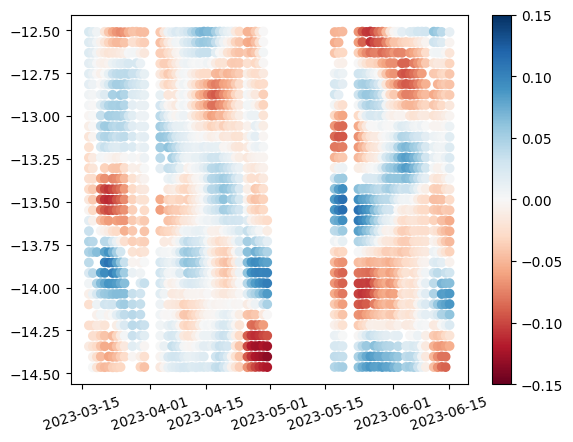

In [5]:
%%time

covfunc = K_itide_3d
eta = 0.04
dx = 100.
dy = 100.
dt = 7.
lx = 95.
ly = 95.
lt = 0.5

noise = 0.001

cov_kwargs = {'itfunc':cov.matern32}
#####

covparams = (eta, dx, dy, dt, lx, ly, lt)

GP = GPtideScipy(XYT, XYT.copy(), noise, covfunc, covparams, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

# Alternative itide model
(no spatial oscillatory component, gamma-exp instead of matern)



In [33]:
def calc_dist(x, xpr, eps=1e-14):
    dx2 = np.power(x-xpr, 2.)
    dx2[dx2<eps] = eps
    return np.sqrt(dx2)

def gamma_exp(x, xpr, gam, l):
    """γ-exponential covariance function"""
    dx = calc_dist(x, xpr)
    return np.exp(-np.power(dx/l, gam))
    
def oscillate_1d_gamma(x, xpr, params):
    """
    1D Oscillatory kernel
    """
    eta, d, l, gam = params
    
    return eta**2 * gamma_exp(x, xpr, gam, d) * cov.cosine(x, xpr, l)

def K_itide_3d_gamma(x, xpr, params, **kwargs):
    eta, dxy, dt, lt, gamma_t, gamma_xy = params

    # Build the covariance matrix
    C  = gamma_exp(x[:,0,None], xpr.T[:,0,None].T, gamma_xy, dxy, **kwargs)
    C  *= gamma_exp(x[:,1,None], xpr.T[:,1,None].T, gamma_xy, dxy, **kwargs)
    C  *= oscillate_1d_gamma(x[:,2,None], xpr.T[:,2,None].T, (1, dt, lt, gamma_t), **kwargs)
    C *= eta**2

    return C

def K_meso_3d_gamma(x, xpr, params):
    eta, lxy, lt, gamma_mxy, gamma_mt = params

    # Build the covariance matrix
    C  = gamma_exp(x[:,0,None], xpr.T[:,0,None].T, gamma_mxy, lxy)
    C  *= gamma_exp(x[:,1,None], xpr.T[:,1,None].T, gamma_mxy, lxy)
    C  *= gamma_exp(x[:,2,None], xpr.T[:,2,None].T, gamma_mt, lt)
    C *= eta**2

    return C

def K_meso_itide_3d_gamma(x, xpr, params):
    eta_m, lxy_m, lt_m, gamma_mxy, gamma_mt, \
        eta_it, dxy_it, dt_it, lt_it, gamma_it, gamma_ixy = params

    C = K_meso_3d_gamma(x, xpr, (eta_m, lxy_m, lt_m, gamma_mxy, gamma_mt))
    C += K_itide_3d_gamma(x, xpr, (eta_it, dxy_it, dt_it, lt_it, gamma_it, gamma_ixy))
    return C
    

CPU times: user 1.46 s, sys: 159 ms, total: 1.62 s
Wall time: 1.4 s


(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(19431.0, 0, '2023-03-15'),
  Text(19448.0, 0, '2023-04-01'),
  Text(19462.0, 0, '2023-04-15'),
  Text(19478.0, 0, '2023-05-01'),
  Text(19492.0, 0, '2023-05-15'),
  Text(19509.0, 0, '2023-06-01'),
  Text(19523.0, 0, '2023-06-15')])

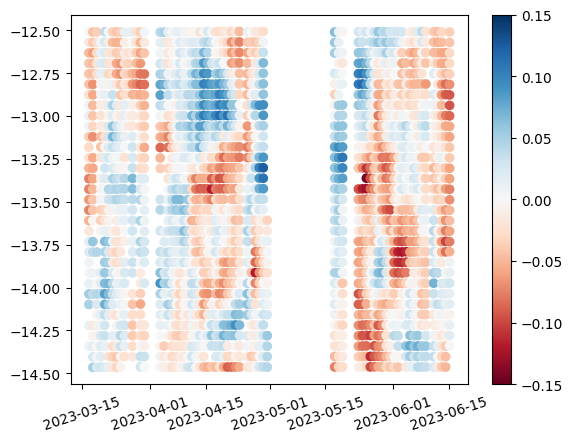

In [34]:
%%time

covfunc = K_itide_3d_gamma
eta = 0.04
dxy = 25.
dt = 3.
lt = 0.5
gamma_t = 1.5
gamma_xy = 1.5

noise = 0.001

cov_kwargs = {}
#####

covparams_it = (eta, dxy, dt, lt, gamma_t, gamma_xy)

GP = GPtideScipy(XYT, XYT.copy(), noise, covfunc, covparams_it, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(19431.0, 0, '2023-03-15'),
  Text(19448.0, 0, '2023-04-01'),
  Text(19462.0, 0, '2023-04-15'),
  Text(19478.0, 0, '2023-05-01'),
  Text(19492.0, 0, '2023-05-15'),
  Text(19509.0, 0, '2023-06-01'),
  Text(19523.0, 0, '2023-06-15')])

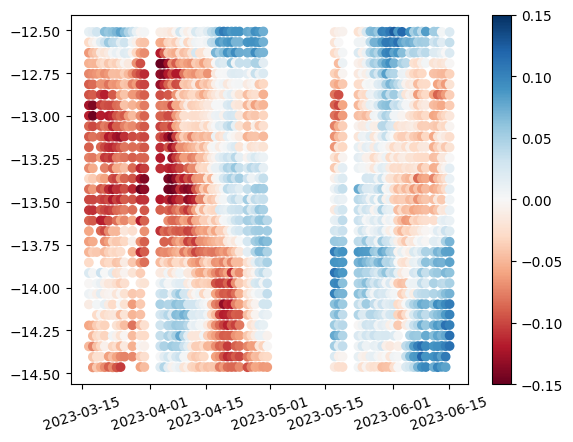

In [35]:
covfunc = K_meso_3d_gamma
eta = 0.05
lxy = 50. 
gamma_mx = 1.5
lt = 10.0
gamma_mt = 1.5

noise = 0.01
cov_kwargs = {}
#####

covparams_m = (eta, lxy, lt, gamma_mx, gamma_mt)

GP = GPtideScipy(XYT, XYT.copy(), noise, covfunc, covparams_m, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(19431.0, 0, '2023-03-15'),
  Text(19448.0, 0, '2023-04-01'),
  Text(19462.0, 0, '2023-04-15'),
  Text(19478.0, 0, '2023-05-01'),
  Text(19492.0, 0, '2023-05-15'),
  Text(19509.0, 0, '2023-06-01'),
  Text(19523.0, 0, '2023-06-15')])

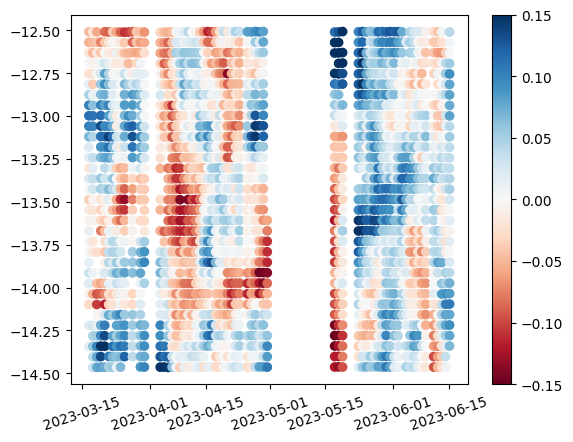

In [37]:
covfunc = K_meso_itide_3d_gamma

covparams =  covparams_m + covparams_it

GP = GPtideScipy(XYT, XYT.copy(), noise, covfunc, covparams, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

# Mesoscale eddy covariance

$$
K_{M}(x, y, t; x', y', t') = \mathcal{M}_{\nu}(x,x'; \lambda_x,\nu)  \times 
\mathcal{M}_{\nu}(y,y'; \lambda_y,\nu)\times 
 \mathcal{M}_{\nu}(t,t'; \lambda_t,\nu)
$$

where

 - $\mathcal{M}_{\nu}$ is a general Matern function
 - $\lambda_x$, $\lambda_y$ are eddy decorrelation length scales
 - $\lambda_t$ are eddy decorrelation time scales
 
**BIG QUESTION**
 
*Is the "eddy-$\nu$"  (i.e. the spectral slope) related to the "internal wave-$\nu$" (i.e. the spectral hump shape)????*

In [6]:
def K_meso_3d(x, xpr, params, mesofunc=cov.matern32):
    eta, lx, ly, lt = params

    # Build the covariance matrix
    C  = mesofunc(x[:,0,None], xpr.T[:,0,None].T, lx)
    C  *= mesofunc(x[:,1,None], xpr.T[:,1,None].T, ly)
    C  *= mesofunc(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= eta**2

    return C

(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(19431.0, 0, '2023-03-15'),
  Text(19448.0, 0, '2023-04-01'),
  Text(19462.0, 0, '2023-04-15'),
  Text(19478.0, 0, '2023-05-01'),
  Text(19492.0, 0, '2023-05-15'),
  Text(19509.0, 0, '2023-06-01'),
  Text(19523.0, 0, '2023-06-15')])

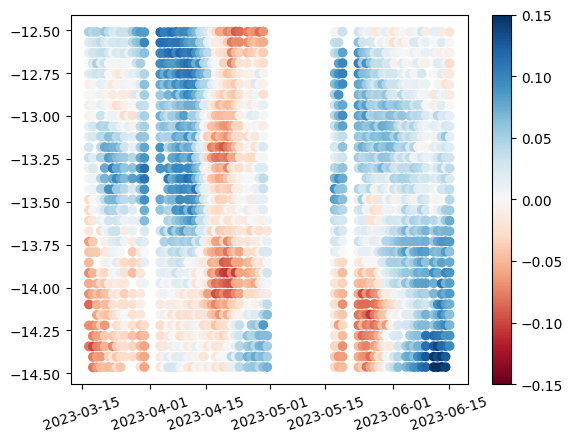

In [7]:
covfunc = K_meso_3d
eta = 0.05
lx = 50.
ly = 50.
lt = 10.0

noise = 0.01
cov_kwargs = {'mesofunc':cov.matern32}
#####

covparams = (eta, lx, ly, lt)

GP = GPtideScipy(XYT, XYT.copy(), noise, covfunc, covparams, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

# Parameter estimation

In [7]:
from gptide import mle

In [22]:
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

In [ ]:
# MCMC

from gptide import mcmc

covfunc = K_itide_3d
cov_kwargs = {'itfunc':cov.matern32}


noise_prior      = gpstats.truncnorm(0.01, 0.02, 1e-15, 1)           # noise 

covparams_priors = [gpstats.truncnorm(0.03, 0.01, 1e-5, 1),                   # eta   
                    #gpstats.truncnorm(100, 20, 1e-15, 1e3), # d_x 
                    #gpstats.truncnorm(100, 20, 1e-15, 1e3), # d_y
                    #gpstats.truncnorm(14, 3, 1e-15, 24),    # d_t
                    gpstats.truncnorm(150, 30, 1e-15, 1e3), # d_x 
                    gpstats.truncnorm(150, 30, 1e-15, 1e3), # d_y 
                    #gpstats.truncnorm(7, 1, 1e-15, 14),    # d_t (v2)
                    gpstats.truncnorm(7, 1, 1e-15, 20),    # d_t (v3)
                    gpstats.truncnorm(75, 25, 1e-15, 150),  # l_x
                    gpstats.truncnorm(75, 25, 1e-15, 150),  # l_y
                    #gpstats.truncnorm(12.42/24, 0.1, 6/24, 1.), # l_t (v2)
                    gpstats.truncnorm(12.42/24, 0.1, 8/24, 16/24.), # l_t (v3)

                   ]

samples, log_prob, priors_out, sampler = mcmc.mcmc( XYT,
                                                    swot.ssh_iwatlas.values[:,None],
                                                    covfunc,
                                                    covparams_priors,
                                                    noise_prior,
                                                    gp_kwargs=cov_kwargs,
                                                    nwarmup=200,
                                                    nwalkers=100,
                                                    niter=20,
                                                    verbose=False,
                                                   parallel=True,
                                                   )

labels = ['σ','η','d_x','d_y','d_t','ℓ_x', 'ℓ_y','ℓ_t']



priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

samples_az.to_netcdf('../DATA/swot_nadir_GP_itide_samples_v4.nc')
priors_out_az.to_netcdf('../DATA/swot_nadir_GP_itide_priors_v4.nc')

Running burn-in...


 85%|████████▌ | 170/200 [1:26:33<13:10, 26.36s/it]

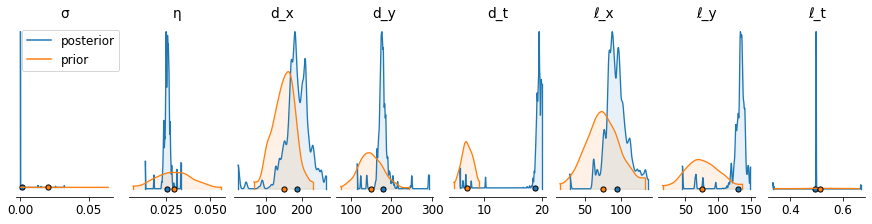

In [11]:


axs = az.plot_density(   [samples_az[labels],
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 8),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

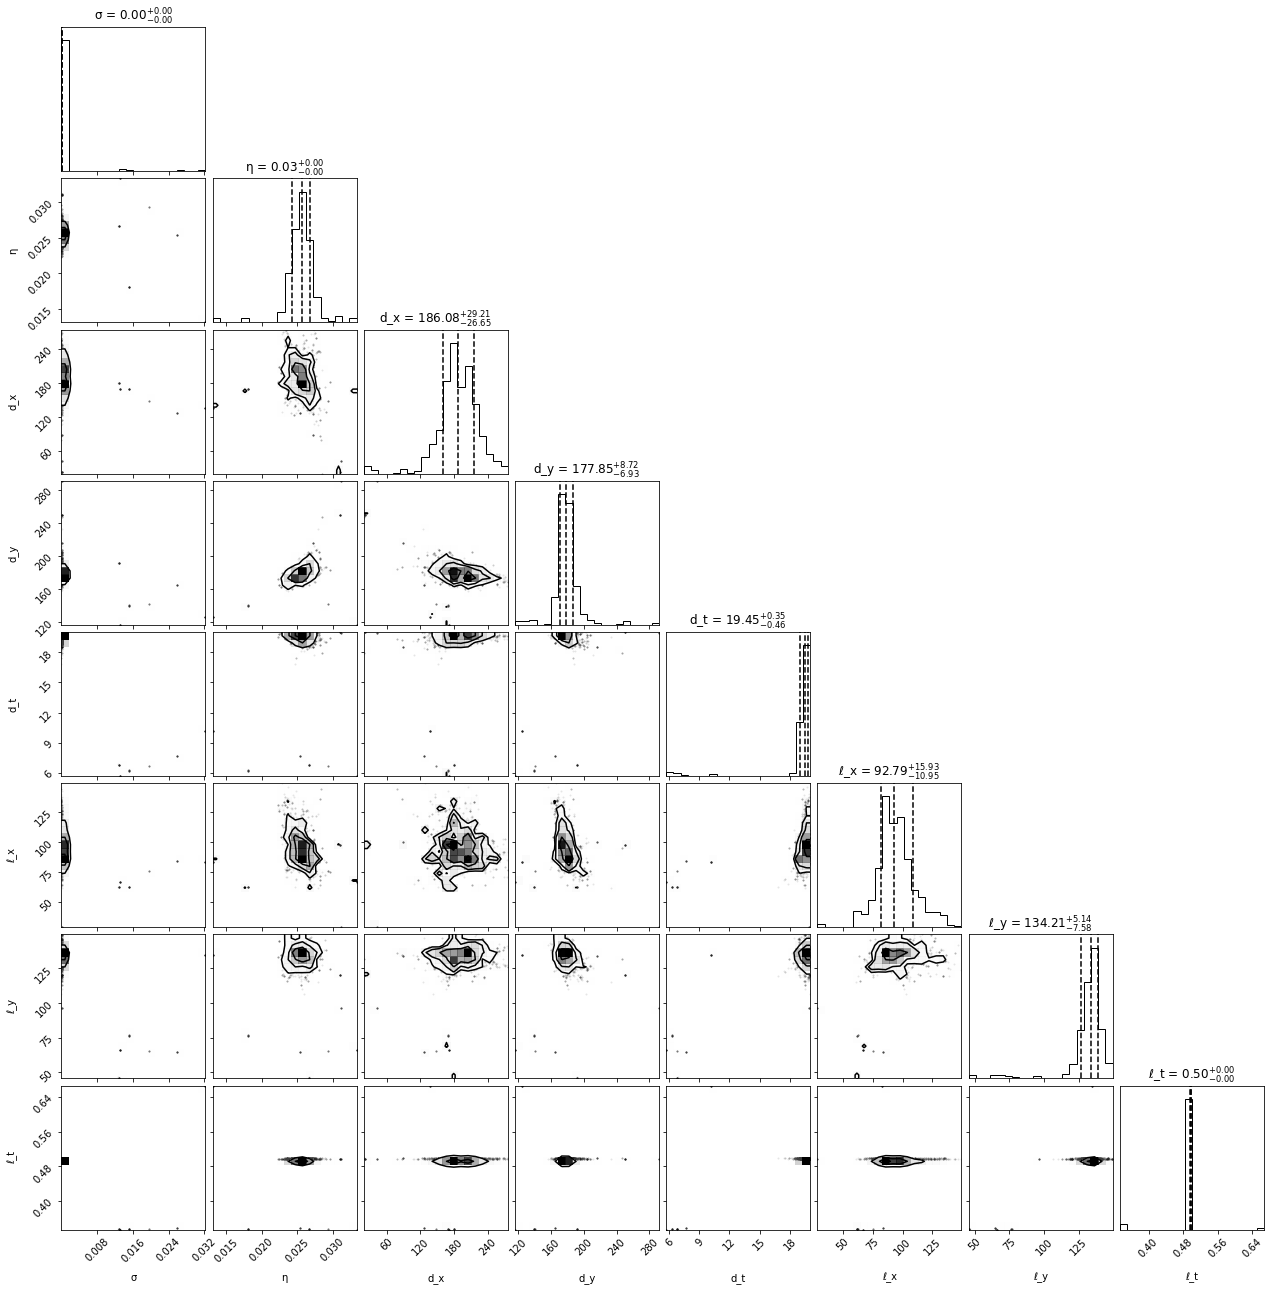

In [12]:
fig = corner.corner(samples,
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])



# Use jax



In [18]:
from gptide import GPtideJax
from gptide import mcmcjax
from gptide import covjax as covj

In [19]:
def oscillate_1d_jax(x, xpr, params, itfunc=covj.matern12):
    """
    1D Oscillatory kernel
    """
    eta, d, l = params
    
    return eta**2 * itfunc(x, xpr, d) * covj.cosine(x, xpr, l)

def K_itide_3d_jax(x, xpr, params, **kwargs):
    eta, dx, dy, dt, lx, ly, lt = params

    # Build the covariance matrix
    C  = oscillate_1d_jax(x[:,0,None], xpr.T[:,0,None].T, (1, dx, lx), **kwargs)
    C  *= oscillate_1d_jax(x[:,1,None], xpr.T[:,1,None].T, (1, dy, ly), **kwargs)
    C  *= oscillate_1d_jax(x[:,2,None], xpr.T[:,2,None].T, (1, dt, lt), **kwargs)
    C *= eta**2

    return C

In [20]:
noise_prior      =mcmcjax.JaxPrior('truncnorm', 0.4, 0.25, 1e-15, 100.)                 # noise - true value 0.5
covparams_priors = [mcmcjax.JaxPrior('truncnorm', 1, 1, 1e-15, 100.),   # η - true value 1.5
                    mcmcjax.JaxPrior('truncnorm', 125, 50, 1e-15, 10000.)  # ℓ - true value 100
                   ]

noise_prior      = mcmcjax.JaxPrior('truncnorm',0.01, 0.02, 1e-15, 1)           # noise 

covparams_priors = [mcmcjax.JaxPrior('truncnorm',0.03, 0.01, 1e-5, 1),                   # eta   
                    mcmcjax.JaxPrior('truncnorm',150, 30, 1e-15, 1e3), # d_x 
                    mcmcjax.JaxPrior('truncnorm',150, 30, 1e-15, 1e3), # d_y 
                    mcmcjax.JaxPrior('truncnorm',7, 1, 1e-15, 20),    # d_t (v3)
                    mcmcjax.JaxPrior('truncnorm',75, 25, 1e-15, 150),  # l_x
                    mcmcjax.JaxPrior('truncnorm',75, 25, 1e-15, 150),  # l_y
                    mcmcjax.JaxPrior('truncnorm',12.42/24, 0.1, 8/24, 16/24.), # l_t (v3)
                   ]

covfunc = K_itide_3d_jax

In [26]:
%%time

samples, priors_out = mcmcjax.mcmcjax( XYT,
                                swot.ssh_iwatlas.values[:,None],
                                covfunc,
                                covparams_priors,
                                noise_prior,
                                nwarmup=1500,
                                niter=500,
                                   )



Running window adaptation



Iteration 25 / 500
Iteration 50 / 500
Iteration 75 / 500
Iteration 100 / 500
Iteration 125 / 500
Iteration 150 / 500
Iteration 175 / 500
Iteration 200 / 500
Iteration 225 / 500
Iteration 250 / 500
Iteration 275 / 500
Iteration 300 / 500
Iteration 325 / 500
Iteration 350 / 500
Iteration 375 / 500
Iteration 400 / 500
Iteration 425 / 500
Iteration 450 / 500
Iteration 475 / 500
Iteration 500 / 500
CPU times: user 12h 49min 49s, sys: 2h 29min 7s, total: 15h 18min 56s
Wall time: 5h 22min 34s


In [27]:
labels = ['σ','η','d_x','d_y','d_t','ℓ_x', 'ℓ_y','ℓ_t']

samples2=np.asarray(samples[0])

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples2, labels)

samples_az.to_netcdf('../DATA/swot_nadir_GP_itide_samples_jax_v2.nc')
priors_out_az.to_netcdf('../DATA/swot_nadir_GP_itide_priors_jax_v2.nc')

# Rotated internal wave model

In [9]:
def get_Rx(phi):
    return np.array([[1., 0., 0.],
                   [0., np.cos(phi), -np.sin(phi)],
                   [0., np.sin(phi), np.cos(phi)]])

def get_Ry(theta):
    return np.array([[np.cos(theta), 0., np.sin(theta)],
                   [0, 1., 0.],
                   [-np.sin(theta), 0., np.cos(theta)]])

def get_Rz(psi):
    return np.array([[np.cos(psi), -np.sin(psi), 0.],
                  [np.sin(psi), np.cos(psi),0.],
                   [0., 0., 1.]])
    
def rotate_3d(XYT, theta_yt, theta_xt, theta_xy):
    
    # N.B. @ is shorthand for np.matmul
    R = get_Rz(theta_xy) @ get_Ry(theta_xt) @ get_Rx(theta_yt)
    
    # Do the rotation
    return  R @ XYT

def K_itide_rotated_3d(x, xpr, params, **kwargs):
    eta, dx, dy, dt, lx, ly, lt, theta_xy = params
    
    x_r = rotate_3d(x.T, 0., 0., theta_xy).T
    xpr_r = rotate_3d(xpr, 0., 0., theta_xy)

    # Build the covariance matrix
    C  = oscillate_1d(x_r[:,0,None], xpr_r.T[:,0,None].T, (1, dx, lx), **kwargs)
    C  *= oscillate_1d(x_r[:,1,None], xpr_r.T[:,1,None].T, (1, dy, ly), **kwargs)
    C  *= oscillate_1d(x_r[:,2,None], xpr_r.T[:,2,None].T, (1, dt, lt), **kwargs)
    C *= eta**2

    return C

CPU times: user 1.29 s, sys: 273 ms, total: 1.56 s
Wall time: 1.23 s


(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

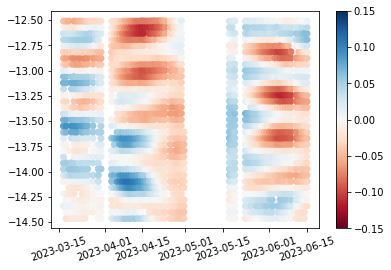

In [17]:
%%time

covfunc = K_itide_rotated_3d
eta = 0.04
dx = 200.
dy = 200.
dt = 20.
lx = 100.
ly = 30.
lt = 0.5

theta_xy = -60 * np.pi/180

noise = 0.001

cov_kwargs = {'itfunc':cov.matern32}
#####

covparams = (eta, dx, dy, dt, lx, ly, lt, theta_xy)

GP = GPtideScipy(XYT, XYT.copy(), noise, covfunc, covparams, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

# Combined internal tide and GP model

In [52]:
def K_meso_it(x, xpr, params, mesofunc=cov.matern32, itfunc=cov.matern32):
    eta_i, dx_i, dy_i, dt_i, lx_i, ly_i, lt_i, eta_m, lx_m, ly_m, lt_m = params
    
    K = K_itide_3d(x, xpr, (eta_i, dx_i, dy_i, dt_i, lx_i, ly_i, lt_i), itfunc=itfunc)
    K += K_meso_3d(x, xpr, (eta_m, lx_m, ly_m, lt_m), mesofunc=mesofunc)
    return K

(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

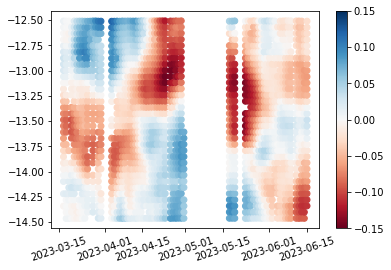

In [53]:
covfunc = K_meso_it
eta_i = 0.01
dx_i = 100.
dy_i = 200.
dt_i = 14.
lx_i = 30.
ly_i = 128.
lt_i = 12.42/24

eta_m = 0.05
lx_m = 50.
ly_m = 50.
lt_m = 10.0


noise = 0.001

cov_kwargs = {}
#####

covparams = (eta_i, dx_i, dy_i, dt_i, lx_i, ly_i, lt_i, eta_m, lx_m, ly_m, lt_m)

GP = GPtideScipy(XYT, XYT.copy(), noise, covfunc, covparams, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

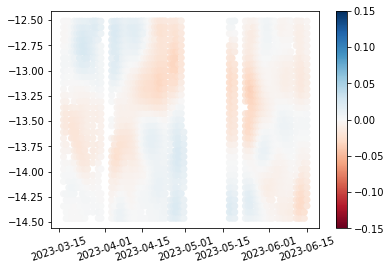

In [54]:
# Plot the internal wave component (filter the mesoscale)

covparams = (eta_i, dx_i, dy_i, dt_i, lx_i, ly_i, lt_i)

noise = eta_m

covfunc = K_itide_3d

GP = GPtideScipy(XYT, XYT.copy(), noise, covfunc, covparams, cov_kwargs=cov_kwargs)

zd_it = GP(zd)

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd_it.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

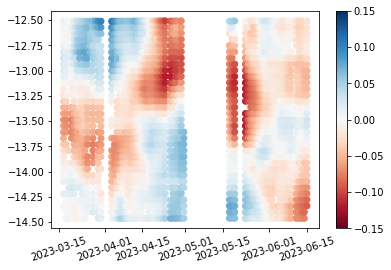

In [55]:

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd.ravel()-zd_it.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

# MCMC the lot...

In [56]:
# MCMC

from gptide import mcmc

covfunc = K_meso_it
cov_kwargs = {}


noise_prior      = gpstats.truncnorm(0.01, 0.02, 1e-15, 1)           # noise 

covparams_priors = [gpstats.truncnorm(0.02, 0.01, 1e-5, 0.03),                   # eta   
                    gpstats.truncnorm(100, 25, 1e-15, 1e3), # d_x 
                    gpstats.truncnorm(200, 10, 1e-15, 1e3), # d_y 
                    gpstats.truncnorm(20, 5, 1e-15, 30),    # d_t (v3)
                    gpstats.truncnorm(80, 10, 1e-15, 150),  # l_x
                    gpstats.truncnorm(125, 10, 1e-15, 150),  # l_y
                    gpstats.truncnorm(12.42/24, 0.1, 12.42/24-0.2/24, 12.42/24+0.2/24), # l_t (v3)
                    gpstats.truncnorm(0.03, 0.01, 1e-5, 1), # eta_m
                    gpstats.truncnorm(50, 25, 1e-15, 150),  # l_xm
                    gpstats.truncnorm(50, 25, 25, 150),  # l_ym
                    gpstats.truncnorm(10, 5, 2., 30),  # l_tm
                   ]


yd = swot['sla_unfiltered'].values-swot['sla_unfiltered'].values.mean()

samples, log_prob, priors_out, sampler = mcmc.mcmc( XYT,
                                                    yd[:,None],
                                                    covfunc,
                                                    covparams_priors,
                                                    noise_prior,
                                                    gp_kwargs=cov_kwargs,
                                                    nwarmup=200,
                                                    nwalkers=100,
                                                    niter=20,
                                                    verbose=False,
                                                   parallel=True,
                                                   )

labels = ['σ','η','d_x','d_y','d_t','ℓ_x', 'ℓ_y','ℓ_t','η_m','ℓ_xm','ℓ_ym','ℓ_tm']

def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

samples_az.to_netcdf('../DATA/swot_nadir_GP_mesoitide_samples_v2.nc')
priors_out_az.to_netcdf('../DATA/swot_nadir_GP_mesoitide_priors_v2.nc')

Running burn-in...


100%|██████████| 200/200 [2:30:49<00:00, 45.25s/it]  


Running production...


100%|██████████| 20/20 [14:54<00:00, 44.75s/it]


In [47]:
swot 

<xarray.Dataset>
Dimensions:                    (time: 3458)
Coordinates:
  * time                       (time) datetime64[ns] 2023-03-16T17:27:12.8417...
    longitude                  (time) float64 123.2 123.2 123.2 ... 123.3 123.3
    latitude                   (time) float64 -14.34 -14.22 ... -13.67 -13.61
Data variables: (12/13)
    longitude_theoretical      (time) float64 123.1 123.2 123.2 ... 123.3 123.3
    latitude_theoretical       (time) float64 -14.34 -14.22 ... -13.67 -13.61
    distance_from_theoretical  (time) float64 0.5697 0.5678 ... 0.252 0.2516
    cycle                      (time) float64 461.0 461.0 461.0 ... 506.0 506.0
    track                      (time) float64 21.0 21.0 21.0 ... 21.0 21.0 21.0
    sla_unfiltered             (time) float32 0.171 0.126 0.127 ... 0.145 0.156
    ...                         ...
    ib_lf                      (time) float32 0.016 0.016 0.016 ... 0.007 0.007
    ocean_tide                 (time) float32 -0.337 -0.338 ... 0.358 0.356
    internal_tide              (time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mdt                        (time) float32 1.005 1.008 1.01 ... 1.02 1.022
    flag                       (time) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ssh_iwatlas                (time) float64 0.0002649 0.003094 ... -0.006855
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-3 sea ...
    time_coverage_duration:          P23H51M44.812667S
    time_coverage_end:               2023-03-16T23:59:58Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2023-03-16T00:08:13Z
    title:                           NRT SWOT nadir 1day Global Ocean Along t...

(array([19431., 19438., 19448., 19455., 19462., 19469., 19478.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

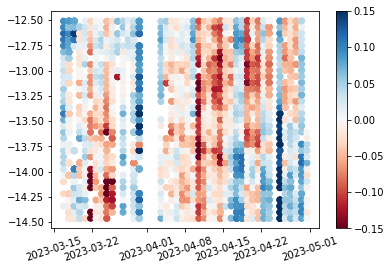

In [45]:
plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=swot['sla_unfiltered']-swot['sla_unfiltered'].mean(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)